<br>

# Técnicas Matemáticas para Big Data - Hidden Markov Models
<br><br>


GROUP 9:
- Inês Matos - Nº 124349 - ??% Work Participation
- João Cardoso - Nº 50750 - ??% Work Participation
- Pedro Rodrigues - Nº 102778 - ??% Work Participation

<br><br>

## 1. Introduction to the problem of study [1,0 valor]

Modelling traffic volumes over time is a fundamental step in modern urban planning, traffic management and infrastructure development. Accurate traffic models provide valuable insights into congestion patterns, peak periods and long-term trends, enabling efficient resource allocation and informed decision making.

Today, as technology advances, there are more and more studies in traffic volume modelling. Considering that it can be influenced by various factors, such as weather conditions, time of day and other external events, the definition of an appropriate strategy becomes a crucial factor in understanding traffic efficiency. The research community has explored various methods to model traffic volumes over time, including traditional time series analysis, machine learning and deep learning techniques [[1]](https://www.sciencedirect.com/science/article/pii/S2210537922000725?ref=pdf_download&fr=RR-2&rr=8e4a7e803e565bec).

In this work, we aim to develop a system based on Hidden Markov Models that is capable of modelling traffic volumes over time. Hidden Markov models are able to deal with temporal sequences and are flexible in modelling relationships between hidden states (not directly observable) and observations (evaluated data).

In this sense, we used the "Metro Interstate Traffic Volume" dataset available at the UCI Machine Learning Repository, which contains hourly traffic volume data for an interstate highway in the United States.

<br><br>
## 2. Brief and general description of the approach and methods used [1,5 valor]

In order to develop an end-to-end system based on Hidden Markov Models capable of modeling the traffic volume in the interstate 94 highway, we followed a structured approach that included the following steps:

1. **Data analysis and preprocessing**: We started by analyzing the dataset and preprocessing it in order to make it suitable for the development of the Hidden Markov Model. As it will be detailed in section 6, the chosen dataset contains both numerical and categorical features. To facilitate the application of the Hidden Markov Model, we decided to encode the numerical features to different categories. Examples of these features are the temperature, the hour of the day, and the traffic volume itself. We also discarded some features that we considered irrelevant as they would not contribute to the model's performance.

2. **Generate the set of possible observations**: As the dataset used is multivariate, which means that it contains multiple features (e.g. temperature, weather, etc.), and since the `hmmlearn` library only accepts a single type of observation (e.g. weather: sunny, rainy, cloudy), we had to generate a set of possible observations. In other words, we had to encode the dataset in such a way that each observation is represented by a single feature.

3. **Map observations and hidden states to integers**: In order to facilitate the implementation of the Hidden Markov Model, we mapped the observations and hidden states to integers. This way, we could use the ```hmmlearn``` library to build the model.

4. **Get the transition matrix and the emission matrix**: As the dataset already contains the traffic volume, we used a subsection of it to calculate the transition matrix and the emission matrix. The transition matrix represents the probability of transitioning from one state to another, while the emission matrix represents the probability of observing a certain feature given a state.

5. **Setup the Hidden Markov Model**: Finally, we created the Hidden Markov Model using the `CategoricalHMM` class from the `hmmlearn` library. We then assigned the transition matrix and the emission matrix to the model.

6. **Model evaluation**: We considered two different scenarios to evaluate the model's performance.

<br><br>
## 3. Brief History and literature review of the problem and methods/algorithms [1,5 valor]

As previously mentioned, modelling data relating to traffic volume has been a topic covered in data science due to its importance in urban planning and transport optimisation. Since the 1970s, there have been models for forecasting and analysing this traffic, namely linear regression models and traditional statistical analysis. However, the increase in the complexity of networks has encouraged the study of slightly more complex models.

Thus, Leonard E. Baum and other researchers introduced statistical methods of Markov source and hidden Markov modelling in the late 1960s and early 1970s. These hidden Markov models are statistical models used in many real-world applications and communities, and they have become prevalent in recent decades, as evidenced by a large number of published articles [2].

As mentioned in the article "Mor, B. (2021), HMMs are widely used in  ​​speech recognition (25% of articles) and human activity recognition (25% of articles). Furthermore, HMMs are also used in musicology (9% of articles), data processing (7% of articles), and network analysis (6% of articles) [3].

In the traffic domain, HMMs are particularly suited to modelling dynamic traffic behaviour such as volume variations and seasonal patterns, where hidden states can represent traffic conditions (e.g., free, moderate, congested), and observations can include variables such as volume, average speed and weather conditions. It is, therefore, essential to refer to its ability to capture temporal dependencies and relate external factors to traffic conditions.

It is also important to mention several articles that sought to use the model in question within the topic of traffic. Thus, it was in the Short-Term article "Traffic Volume Prediction for Sustainable Transportation in an Urban Area", published in 2013, that the authors proposed a model called Absorbent Markov Chain (AMC) that used a historical traffic database in a single time series so that they can predict the short-term traffic volume on road links and determine the rate of traffic reduction after congestion occurs. It should also be noted that two sets of measured traffic volume data collected in Enschede, Netherlands, were used for training and testing the model. In the article "Congestion Pattern Prediction for a Busy Traffic Zone Based on the Hidden Markov Model," published in 2021, HMM was used. A correlation was established between the state of external road traffic (observation state) and internal road traffic (hidden state) of a high-traffic zone. It was concluded that the prediction accuracy can reach 83.4%, 5.8% higher than that of the autoregressive moving average model. Finally, in the article "A Hidden Markov Model for Short-term Prediction of Traffic Conditions on Freeways," published in 2014, the authors gathered data from real-time traffic monitoring devices for six years in a 60.8 km corridor (38 miles) from Interstate-4 in Orlando, Florida. Thus, using HMM, they estimated the most likely sequence and traffic states and concluded that the HMM approach successfully predicted short-term traffic conditions during peak periods and accounted for the inherently stochastic nature of traffic conditions. 

In this sense, throughout the research, we sought to understand the historical path of modelling methods that could be used and continued using HHM to model and interpret traffic patterns on interstate I-94.

<br><br>
## 4. About the main method/algorithm used [1,5 valor]

The objective for this work was to identify latent states in traffic volume that are not readily available from the selected features to model. This is the basic principle for Hidden Markov Models, whereby modeling a dataset with a target hidden feature (traffic volume, in our case), we can learn the probabilities for given states to occur without directly assessing feature directly.  The probabilities are estimated from the dataset, allowing to create the transition matrix, where the number of transitions between events of the hidden observable are counted  and normalized. A similar approach is taken to create the emission matrix, where the frequency of each observation is counted for each of the states of the hidden variable are counted and normalized. In this case, we are dealing with supervised learning in the Hidden Markov Model.

<br><br>

## 5. Python imports and global configurations [0,5 valor]

In [1]:
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from hmmlearn import hmm
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from utils import graph_visualization

<br><br>

## 6. Dataset and variables explanation [1,5 valor]

The dataset used for this assignment was the "Metro Interstate Traffic Volume" [[TODO]](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) dataset, available on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/). This dataset contains hourly traffic volume data for the Interstate 94 highway in Minneapolis-St Paul, MN, USA. The dataset records traffic volume from 2012-10-02 to 2018-09-30.

This dataset is a multivariate time series dataset, containing 48204 instances and 9 different features. The features and their descriptions are as follows:

| Name                | Description                                       | Type         | Units  |
|---------------------|---------------------------------------------------|--------------|--------|
| holiday             | US National holidays plus regional holiday, Minnesota State Fair | Categorical  |   -     |
| temp                | Average temp in kelvin                            | Continuous   | Kelvin |
| rain_1h             | Amount in mm of rain that occurred in the hour    | Continuous   | mm     |
| snow_1h             | Amount in mm of snow that occurred in the hour    | Continuous   | mm     |
| clouds_all          | Percentage of cloud cover                         | Integer      | %      |
| weather_main        | Short textual description of the current weather  | Categorical  |   -     |
| weather_description | Longer textual description of the current weather | Categorical  |   -     |
| date_time           | Hour of the data collected in local CST time      | Date         |   -     |
| traffic_volume (target)     | Hourly I-94 ATR 301 reported westbound traffic volume | Integer      |   -     |

As mentioned in section 2, in order to use different types of observations in the Hidden Markov Model, we need to create a set of possible observations. This implies that we create all possible combinations of the features in the dataset. In order to reduce the number of possible observations, we only considered the following features: `date-time`, `temperature`, and `weather_main`.

The preprocessing  is presented below.

### Data preprocessing

In [2]:
df = pd.read_csv('METRO Interstate/Metro_Interstate_Traffic_Volume.csv')

- Instead of using the date-time feature as is, we decided to extract the hour of the day from it and then categorize it into 4 different categories: `morning`, `afternoon`, `evening`, and `night`. 

- The temperature feature was also categorized into 5 different categories: `cold`, `cool`, `mild`, `warm`, and `hot`.

- Although the weather_main feature is already categorical, as it can be seen in the plot below, several categories have very few samples. Therefore, we decided to group the categories `Drizzle`, `Haze`, `Thunderstorm`, `Fog`, `Smoke`, and `Squall` into a single category called `other`. Doing this, we reduce the number of possible observations.

- As the traffic volume highly depends if it is weekday or weekend, we decided to create a new feature called `weekend` that indicates if the day is a weekend or not.

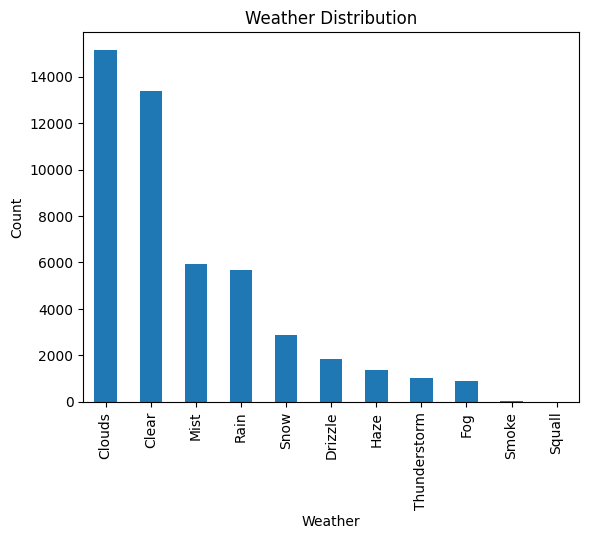

In [3]:
df['weather_main'].value_counts().plot(kind='bar')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.title('Weather Distribution')
plt.show()

In [4]:
time_of_day = {
    "night": range(0, 6),
    "morning": range(6, 12),
    "afternoon": range(12, 18),
    "evening": range(18, 24)
}

temperature = {
    "cold": range(-30, 0),
    "cool": range(0, 10),
    "mild": range(10, 20),
    "warm": range(20, 30),
    "hot": range(30, 50)
}

other_weather = ['Drizzle', 'Haze', 'Fog', 'Thunderstorm', 'Squall', 'Smoke']

In [5]:
def kelvin_to_celsius(k):
    return round(k - 273.15)

def get_time_of_day(x):
    hour = int(x.split(' ')[1].split(':')[0])
    for time_category, time_range in time_of_day.items():
        if hour in time_range:
            return time_category
        
def is_weekend(x):
    date = x.split(' ')[0]
    year, month, day = date.split('-')
    weekday = datetime(int(year), int(month), int(day)).weekday()
    return 1 if weekday >= 5 else 0

def get_temp_category(x):
    for temp_category, temp_range in temperature.items():
        if x in temp_range:
            return temp_category

def convert_weather(x):
    return 'other' if x in other_weather else x.lower()

In [6]:
df['temp'] = df['temp'].apply(kelvin_to_celsius)
df = df[df['temp'] > -50] # remove outliers

df['temp'] = df['temp'].apply(get_temp_category)
df['time_of_day'] = df['date_time'].apply(get_time_of_day)
df['weekend'] = df['date_time'].apply(is_weekend)
df['weather'] = df['weather_main'].apply(convert_weather)

df = df.drop(columns=['holiday', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'])
order = ['date_time', 'temp', 'time_of_day', 'weather', 'weekend', 'traffic_volume']
df = df[order]

### Categorize the traffic volume

In order to categorize the traffic volume, we took in consideration the quartiles of the traffic volume. 

The traffic volume was categorized into 4 different categories: `low`, `medium`, `high`, and `very high`:
- `low`: traffic volume < 1193
- `medium`: 1193 <= traffic volume < 3380
- `high`: 3380 <= traffic volume < 4933
- `very high`: traffic volume >= 4933


In [7]:
q1 = df['traffic_volume'].quantile(0.25).astype(int)
q2 = df['traffic_volume'].quantile(0.5).astype(int)
q3 = df['traffic_volume'].quantile(0.75).astype(int)
print(q1, q2, q3)

1194 3380 4933


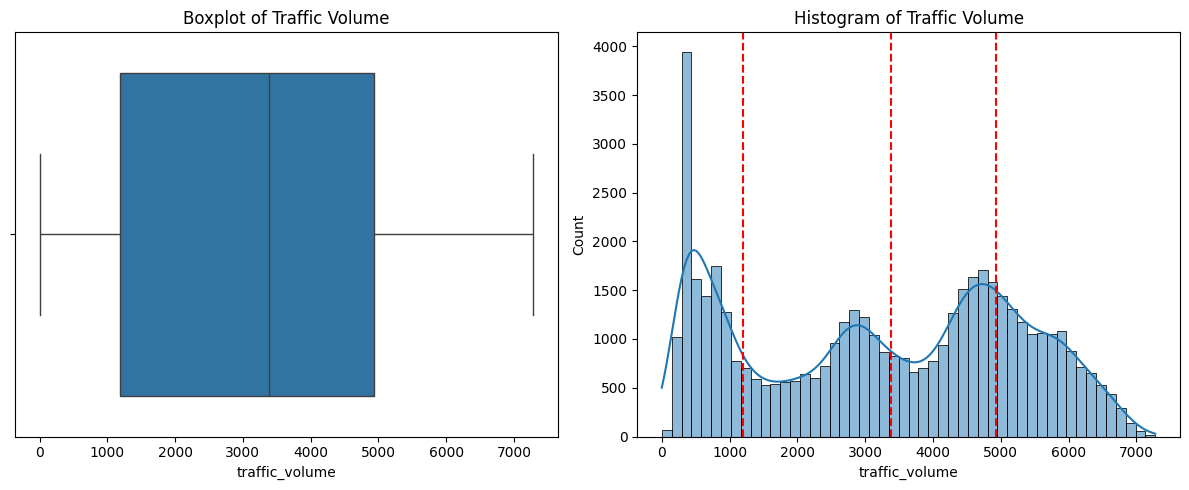

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(x='traffic_volume', data=df, ax=axes[0])
axes[0].set_title('Boxplot of Traffic Volume')

# Histogram
sns.histplot(df['traffic_volume'], bins=50, ax=axes[1], kde=True)
axes[1].set_title('Histogram of Traffic Volume')

# Quartiles
for q in [q1, q2, q3]:
    plt.axvline(q, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [9]:
min_traffic = df['traffic_volume'].min()
max_traffic = df['traffic_volume'].max()

traffic_categories = {
    'low_volume': (min_traffic, q1),
    'medium_volume': (q1, q2),
    'high_volume': (q2, q3),
    'very_high_volume': (q3, max_traffic + 1)
}

def categorize_traffic_volume(volume):
    volume = int(volume)
    for category, (lower, upper) in traffic_categories.items():
        if lower <= volume < upper:
            return category
        
df['traffic_volume_category'] = df['traffic_volume'].apply(categorize_traffic_volume)

In [10]:
df.to_csv('data/metro_interstate_traffic_volume_processed.csv', index=False)

<br><br>

## 7. Main code as possible solution to the problem [1,5 valor] 

### Split the dataset
We start by splitting the dataset into training and testing sets. We use the first 80% of the dataset to calculate the transition matrix and the emission matrix, and the remaining 20% to evaluate the model.

In [11]:
X = df.drop(columns=['traffic_volume', 'traffic_volume_category'])
y = df['traffic_volume_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Generate the set of possible observations

To obtain the set of possible observations, we generate all possible combinations of the features `weekend`, `time_of_day`, `weather`, and `temperature`. We then map these combinations to integers as the `hmmlearn` library only accepts integers as observations.

After some testing, we found that the model performs better without the `temperature` feature. Therefore, we decided to remove it from the set of possible observations.

In [12]:
day_of_week_categories = ['weekday', 'weekend']
time_of_day_categories = df['time_of_day'].unique()
weather_categories = df['weather'].unique()
temp_categories = df['temp'].unique()
traffic_categories = df['traffic_volume_category'].unique()

observations = list(product(day_of_week_categories, time_of_day_categories, weather_categories))
observations = ['_'.join(obs) for obs in observations]

print("Example of observations:")
for obs in observations[:10]:
    print(obs)
print("\nTotal number of observations:", len(observations))

Example of observations:
weekday_morning_clouds
weekday_morning_clear
weekday_morning_rain
weekday_morning_other
weekday_morning_mist
weekday_morning_snow
weekday_afternoon_clouds
weekday_afternoon_clear
weekday_afternoon_rain
weekday_afternoon_other

Total number of observations: 48


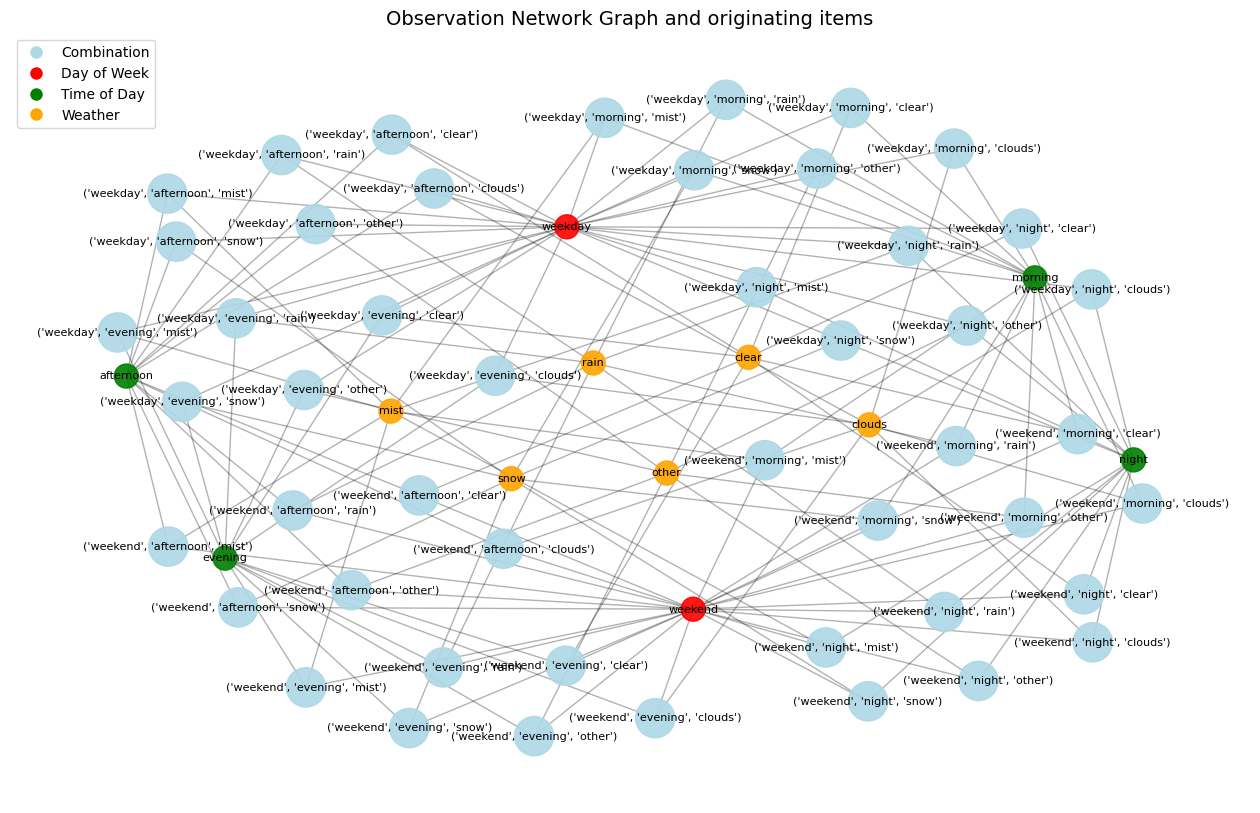

In [13]:
graph_visualization(day_of_week_categories, time_of_day_categories, weather_categories)

### Mapping the observations and traffic states to integers

In [14]:
observations_map = {
    obs: i for i, obs in enumerate(observations)
}

state_map = {
    'low_volume': 0,
    'medium_volume': 1,
    'high_volume': 2,
    'very_high_volume': 3
}


def get_observation(row):
    weekday = 'weekend' if row['weekend'] == 1 else 'weekday'
    obs = f"{weekday}_{row['time_of_day']}_{row['weather']}"
    return observations_map[obs]

def get_sequence(data):
    return data.apply(get_observation, axis=1).values.reshape(-1, 1)

In [15]:
print(state_map)

{'low_volume': 0, 'medium_volume': 1, 'high_volume': 2, 'very_high_volume': 3}


### Transition and emission probabilities

As already mentioned, as we already know the traffic volume category for each instance, we took this as advantage to model the system. We used the train subsection of the dataset to calculate the transition matrix and the emission matrix. Additionally, we also calculated the initial state distribution.

In [16]:
def transition_matrix(n_states, states_sequence):
    transition_counts = np.zeros((n_states, n_states))
    for (i, j) in zip(states_sequence[:-1], states_sequence[1:]):
        transition_counts[i, j] += 1

    transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)
    return transition_probs


def emission_matrix(n_states, n_observations, states_sequence, observations_sequence):
    emission_counts = np.zeros((n_states, n_observations))
    for state, obs in zip(states_sequence, observations_sequence):
        emission_counts[state, obs] += 1

    emission_probs = emission_counts / emission_counts.sum(axis=1, keepdims=True)
    return emission_probs


def start_probs(n_states, states_sequence):
    start_counts = Counter(states_sequence)
    start_probs = np.array([start_counts[state] for state in range(n_states)])
    start_probs = start_probs / start_probs.sum()
    return start_probs

In [17]:
n_states = len(traffic_categories)
n_observations = len(observations)

states_sequence = y_train.map(state_map).values
observations_sequence = get_sequence(X_train)

# Transition matrix
transition_probs = transition_matrix(n_states, states_sequence)

# Emission matrix
emission_probs = emission_matrix(n_states, n_observations, states_sequence, observations_sequence)

# Start probability
start_probs = start_probs(n_states, states_sequence)

In [18]:
print("Transition matrix:")
for row in transition_probs:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()
    
print("\nEmission matrix:")
for row in emission_probs:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()

print("\nStart probability:")
for prob in start_probs:
    print(f"{prob:.2f}", end=' ')
print()

Transition matrix:
0.84 0.14 0.00 0.01 
0.15 0.68 0.07 0.09 
0.00 0.16 0.71 0.12 
0.00 0.01 0.21 0.78 

Emission matrix:
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.01 0.00 0.16 0.18 0.07 0.07 0.10 0.04 0.01 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.06 0.09 0.03 0.03 0.04 0.01 
0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.16 0.14 0.06 0.04 0.04 0.03 0.03 0.03 0.01 0.01 0.02 0.01 0.04 0.04 0.01 0.02 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.06 0.06 0.02 0.02 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 
0.09 0.06 0.03 0.03 0.04 0.02 0.06 0.03 0.02 0.02 0.01 0.02 0.07 0.05 0.02 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.03 0.01 0.01 0.01 0.00 0.10 0.06 0.03 0.02 0.02 0.01 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.13 0.11 0.05 0.05 0.08 0.02 0.23 0.13 0.07 0.05 0.03 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0

### Create HMM model

Given the transition matrix, the emission matrix, and the initial state distribution, we created the Hidden Markov Model using the `CategoricalHMM` class from the `hmmlearn` library.

In [19]:
model = hmm.CategoricalHMM(n_components=n_states)
model.startprob_ = start_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

<br><br>

## 8. Analysis of Example 1 [3,0 valor]

For the first example, our main goal is to verify if the solution is able to effectively model the traffic volume of a typical week. In order to select a period of time to evalute the solution, we considered the following criteria:

1. The period is part of the test subset, which means that the model did not consider this data when calculating the transition matrix and the emission matrix.

2. It is a typical week, with no holidays or special events, reproducing a normal week.

3. It contains both weekdays and weekends, where the traffic volume is expected to be different.

Given these criteria, we selected the period from 5th to 13th October 2018. This period contains 7 weekdays and a single weekend. Moreover, it is a uneventful period, meaning that there are no holidays or special events that could affect the traffic volume.

In [20]:
df['date_time'] = pd.to_datetime(df['date_time'])

october_samples = df[
    (df['date_time'].dt.year == 2017) & 
    (df['date_time'].dt.month == 10) & 
    (df['date_time'].dt.day >= 5) &
    (df['date_time'].dt.day <= 13)
]

In [21]:
observations_sequence = get_sequence(october_samples)
actual_states = october_samples['traffic_volume_category'].map(state_map).values

predicted_states = model.predict(observations_sequence)

In [22]:
accuracy = accuracy_score(actual_states, predicted_states)
print(f"Model Accuracy for 5th to 13h October: {accuracy * 100:.2f}%")

f1 = f1_score(actual_states, predicted_states, average='weighted')
print(f"Model F1 Score for 5th to 13h October: {f1 * 100:.2f}%")

log_likelihood = model.score(observations_sequence)
print(f"Log Likelihood for 5th to 13h October: {log_likelihood:.2f}")

Model Accuracy for 5th to 13h October: 77.24%
Model F1 Score for 5th to 13h October: 74.98%
Log Likelihood for 5th to 13h October: -801.62


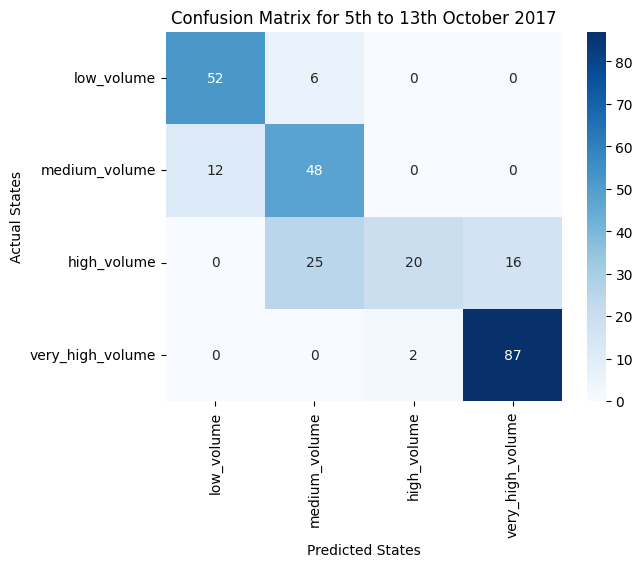

In [23]:
cm = confusion_matrix(actual_states, predicted_states)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=state_map.keys(), yticklabels=state_map.keys(), cmap='Blues')
plt.xlabel("Predicted States")
plt.ylabel("Actual States")
plt.title("Confusion Matrix for 5th to 13th October 2017")
plt.show()


For the selected period, the model reached an accuracy of 0.77, and f1-score of 0.74. Although these results are not perfect, based on the figure bellow where we plot the predicted traffic volume with the actual traffic volume, we can see that the model was able to capture the main patterns for different days, including weekdays and weekends where the traffic volume significantly changes.

On the other hand, from the confusion-matrix for this particular example, we can see that the model classified a considerable amount of samples as 'medium_volume' when they were actually 'high_volume' (total of 25 samples). Based on the figure below, this happened mainly due to some misclassifications on the weekend (3th and 4th days).

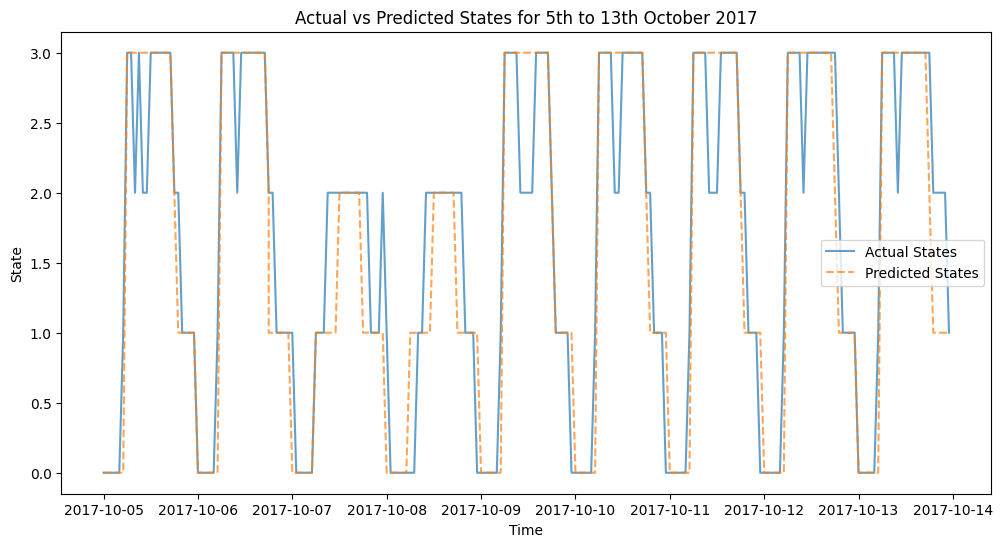

In [24]:
time = october_samples['date_time']

plt.figure(figsize=(12, 6))
plt.plot(time, actual_states, label='Actual States', alpha=0.7)
plt.plot(time, predicted_states, label='Predicted States', linestyle='dashed', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Actual vs Predicted States for 5th to 13th October 2017")
plt.legend()
plt.show()

Still based on the plot, we can also see that the model is not capable of capturing the sudden changes in traffic volume. For example, every time the traffic volume rapidly changes from 'very_high_volume' (state 3) to 'high_volume' (state 2) and then back to 'very_high_volume' (state 3), the model is not able to model these changes, considering the traffic volume as 'very_high_volume' (state 3).

This is the reason why in the confusion matrix, the model classified some samples as 'very_high_volume' when they were actually 'high_volume'. If we recall the frequency distribution of the events for 'high_volume' and 'very_high_volume', the two "curves" that shape these distributions are substantially overlapping. The division that we used could be the reason why these sudden changes occur.

<br><br>

## 9. Analysis of Example 2 [3,0 valor]

For the second example we tested the model in a more challenging scenario, by trying to model the sequence of traffic states during the months of December and January of 2017-2018. During festivities, with several holidays and new years eve, the model had tremendous difficulty to model properly the flows of traffic, with the F1 score dropping to 63 %, a substantial drop from the previous case.

In [25]:
# December 2017
december = df[
    (df['date_time'].dt.year == 2017) & 
    (df['date_time'].dt.month == 12)
]

# January 2018
january = df[
    (df['date_time'].dt.year == 2018) & 
    (df['date_time'].dt.month == 1)
]

december_january = pd.concat([december, january])


In [26]:
observations_sequence = get_sequence(december_january)
actual_states = december_january['traffic_volume_category'].map(state_map).values

predicted_states = model.predict(observations_sequence)

In [27]:
accuracy = accuracy_score(actual_states, predicted_states)
print(f"Model Accuracy for December 2017 to January 2018: {accuracy * 100:.2f}%")

f1 = f1_score(actual_states, predicted_states, average='weighted')
print(f"Model F1 Score for December 2017 to January 2018: {f1 * 100:.2f}%")

log_likelihood = model.score(observations_sequence)
print(f"Log-Likelihood for December 2017 to January 2018: {log_likelihood}")

Model Accuracy for December 2017 to January 2018: 65.95%
Model F1 Score for December 2017 to January 2018: 63.59%
Log-Likelihood for December 2017 to January 2018: -5683.358119005634


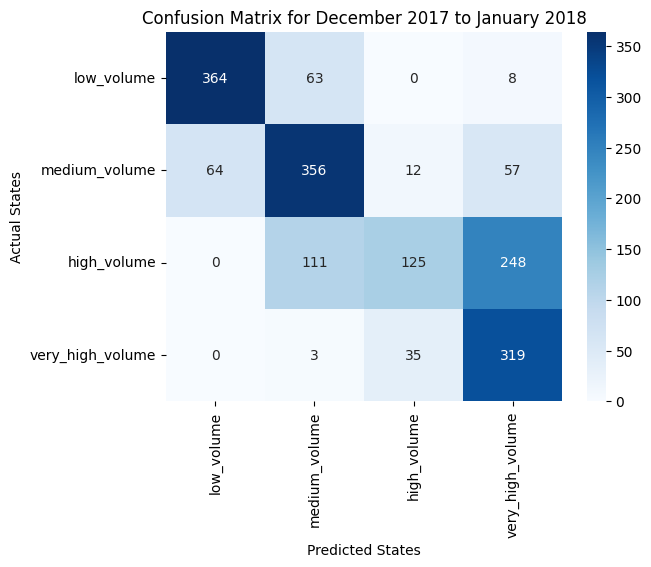

In [28]:
cm = confusion_matrix(actual_states, predicted_states)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=state_map.keys(), yticklabels=state_map.keys(), cmap='Blues')
plt.xlabel("Predicted States")
plt.ylabel("Actual States")
plt.title("Confusion Matrix for December 2017 to January 2018")
plt.show()


The number of cases misattributed between 'high' and 'very high' volume substantially increased, and despite the distribution of the frequency curves between 'medium' and 'low' volume there was a slight increase in mismatched cases as well, although keeping the proportion close to the original value.

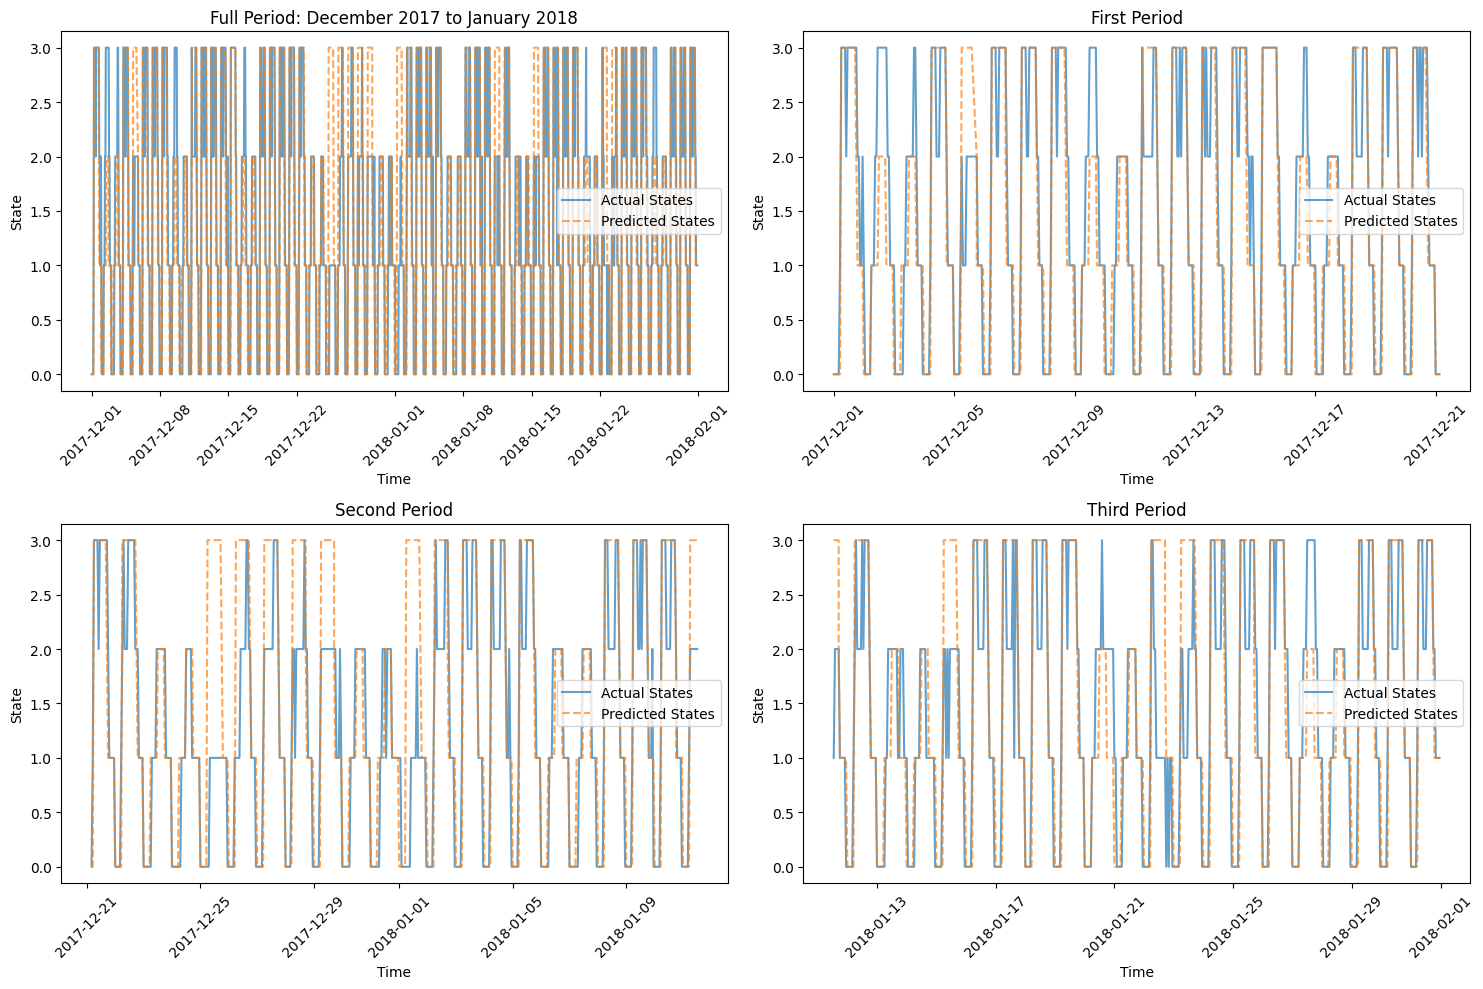

In [29]:
import matplotlib.pyplot as plt
import numpy as np

time = december_january['date_time']
total_points = len(time)

# Split data into three equal periods
split_indices = np.array_split(range(total_points), 3)
time_splits = [time.iloc[indices] for indices in split_indices]
actual_splits = [actual_states[indices] for indices in split_indices]
predicted_splits = [predicted_states[indices] for indices in split_indices]

# Create 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Top-left: Full period
axs[0, 0].plot(time, actual_states, label='Actual States', alpha=0.7)
axs[0, 0].plot(time, predicted_states, label='Predicted States', linestyle='dashed', alpha=0.7)
axs[0, 0].set_title("Full Period: December 2017 to January 2018")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("State")
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

# Other three plots: Truncated periods
titles = ["First Period", "Second Period", "Third Period"]
for i, (time_split, actual_split, predicted_split) in enumerate(zip(time_splits, actual_splits, predicted_splits)):
    row, col = (i + 1) // 2, (i + 1) % 2
    axs[row, col].plot(time_split, actual_split, label='Actual States', alpha=0.7)
    axs[row, col].plot(time_split, predicted_split, label='Predicted States', linestyle='dashed', alpha=0.7)
    axs[row, col].set_title(titles[i])
    axs[row, col].set_xlabel("Time")
    axs[row, col].set_ylabel("State")
    axs[row, col].legend()
    axs[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

As we can see from the figure above the model was incapable of modeling adequately the days during and around the festivities. These cases are clearly out of the dataset made available to create the model, which made an already difficult task (of modeling such a long sequence of states) even harder.

<br><br>
## 10. Pros and cons of the approach [2,0 valor]

Considering the approach used in this work and the results obtained in the two examples, we can identify some pros and cons of using Hidden Markov Models to model traffic volumes over time.

PROS:
- Easy implementation, accurate fitting of sequential data

- Ability to identify the main patterns of traffic during weekdays and weekends

- Highly interpretable and transparent, as the model can be easily interpreted through the transition and emission matrices

- More efficient than other complex models, such as deep learning models, due to the Markov property

- Does not require a large amount of data to provide accurate results, compared to machine learning models


CONS:

- Inability to capture sudden changes in traffic volume, which can lead to misclassifications

- The proposed method does not take into account special events, holidays, or other external factors that can significantly affect traffic volumes.

- The number of possible observations is extremely high when considering a large number of features.

- The model is limited by the Markov property, which assumes that the future state depends only on the current state and not on the sequence of previous states.

<br><br>
## 11. Future improvements [2,0 valor]

There is always room for improvement in any system, and our HMM-based traffic volume modelling system is no exception.

Based on the results obtained in this work and the difficulties faced by the model in some scenarios, we suggest the following improvements:

- Use more robust methods to categorise the numerical features. This could solve the problem of sudden changes in traffic volume.

- Perform feature engineering in such a way that we can integrate holidays and special events so that the model can account for these variations.

- Use PCA to safely reduce the number of features and thus the number of possible observations.

- Evaluate the model on another dataset to understand its ability to generalise.

- Incorporate a more complex model, such as a hybrid Hidden Markov model for mixed continuous/continuous and discrete/continuous observations, as described in [[TODO]](https://ieeexplore.ieee.org/document/7340853). Following this approach, we would not need to categorise the numerical features.

<br>
<div style="text-align: center;">
    <br><br>
    <p style="font-size: 40px;">References [1,0 valor]</p>
</div>
<br>


[1]	B. Medina-Salgado, E. Sánchez-DelaCruz, P. Pozos-Parra, and J. E. Sierra, ["Urban traffic flow prediction techniques: A review"](https://www.sciencedirect.com/science/article/pii/S2210537922000725), Sustainable Computing: Informatics and Systems, vol. 35, p. 100739, 2022.

[TODO] J. Hogue. ["Metro Interstate Traffic Volume,"](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) UCI Machine Learning Repository, 2019. [Online]. Available: https://doi.org/10.24432/C5X60B.

[TODO]	E. Epaillard and N. Bouguila, ["Hybrid hidden Markov model for mixed continuous/continuous and discrete/continuous data modeling"](https://ieeexplore.ieee.org/document/7340853), in 2015 IEEE 17th International Workshop on Multimedia Signal Processing (MMSP), 2015, pp. 1–6.

--- 


[1] UCI Machine Learning Repository, "Metro Interstate Traffic Volume Data Set," [Online]. Available: https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume. [Accessed: Nov. 17, 2024].

[2] L. E. Baum and T. Petrie, "Statistical Inference for Probabilistic Functions of Finite State Markov Chains," The Annals of Mathematical Statistics, vol. 37, no. 6, pp. 1554–1563, 1966, doi: 10.1214/aoms/1177699147.

[3] B. Mor, "Hidden Markov Models: Applications and Trends," Journal of Emerging Research, vol. 12, no. 3, pp. 45–52, 2021.